尝试部署152行附近的fdMWF滤波器

In [27]:
import numpy as np
from scipy.signal import fftconvolve, stft, istft, windows
from numpy.fft import ifft, fftshift
from scipy.io import wavfile
import soundfile as sf
import matplotlib.pyplot as plt


def fdMWF(in_signal, desired, fs, blockLenSmp=None, hopSizeSmp=2048, filterLenSmp=None, regulWeight=1e-4, win=None):
    """
    实现频域多通道维纳滤波器。

    参数：
    in_signal (numpy.ndarray): 输入信号数组。
    desired (numpy.ndarray): 期望信号数组。
    fs (int): 采样频率。
    blockLenSmp (int): 每块的样本长度。默认为0.5 * fs。
    hopSizeSmp (int): 跳步大小（样本）。默认为2048。
    filterLenSmp (int): 滤波器长度（样本）。默认为blockLenSmp / 2。
    regulWeight (float): 正则化权重。默认为1e-4。
    win (numpy.ndarray): 窗函数。默认为全为1的数组。

    返回：
    h (numpy.ndarray): 滤波器系数。
    irShort (numpy.ndarray): 缩短的脉冲响应。
    """

    # 如果未提供参数，则设置默认值
    if blockLenSmp is None:
        blockLenSmp = int(0.5 * fs)
    if filterLenSmp is None:
        filterLenSmp = blockLenSmp // 2
    if win is None:
        win = np.ones(blockLenSmp)

    # 确保输入信号和期望信号具有相同的长度
    if in_signal.shape[0] != desired.shape[0]:
        minLen = min(in_signal.shape[0], desired.shape[0])
        in_signal = in_signal[:minLen]
        desired = desired[:minLen]

    # 确保FFT长度为偶数
    fftLen = blockLenSmp
    if fftLen % 2 == 1:
        fftLen += 1

    # 确保窗口长度不超过信号长度
    blockLenSmp = min(blockLenSmp, len(in_signal))
    win = np.ones(blockLenSmp) if win is None else win[:blockLenSmp]

    # 计算输入信号的STFT
    _, _, stftMtxIn = stft(in_signal, fs=fs, window=win, nperseg=blockLenSmp, noverlap=blockLenSmp - hopSizeSmp, nfft=fftLen)

    # 初始化期望信号的STFT矩阵
    numChannels = desired.shape[1]
    stftMtxDesired = np.zeros((fftLen // 2 + 1, stftMtxIn.shape[1], numChannels), dtype=complex)

    # 分别计算每个通道的STFT
    for ch in range(numChannels):
        _, _, stftMtxDesired[:, :, ch] = stft(desired[:, ch], fs=fs, window=win, nperseg=blockLenSmp, noverlap=blockLenSmp - hopSizeSmp, nfft=fftLen)


    # 计算频率数量、块数量和麦克风数量
    numFreqs = stftMtxDesired.shape[0]
    numBlocks = stftMtxDesired.shape[1]
    numMics = stftMtxDesired.shape[2]

    # 初始化滤波器系数矩阵
    h = np.zeros((numFreqs, numMics), dtype=complex)

    # 对每个频率进行处理
    for ff in range(numFreqs):
        y = stftMtxIn[ff, :].T
        d = stftMtxDesired[ff, :, :]

        # 打印调试信息
#        print(f"Frequency bin: {ff}")
#        print(f"y.shape: {y.shape}, d.shape: {d.shape}")

        # 确保y是二维数组
        if y.ndim == 1:
            y = y[:, np.newaxis]

        # 计算Ryy和Ryd矩阵
        Ryy = (1 / numBlocks) * (y.conj().T @ y)
        Ryd = (1 / numBlocks) * (y.conj().T @ d)

        # 打印调试信息
#        print(f"Ryy.shape: {Ryy.shape}, Ryd.shape: {Ryd.shape}")

        # 求解滤波器系数
        try:
            h[ff, :] = np.linalg.solve(Ryy + regulWeight * np.eye(Ryy.shape[0]), Ryd)
        except np.linalg.LinAlgError:
            h[ff, :] = np.zeros_like(Ryd)  # 处理奇异矩阵情况

    # 计算完整的滤波器频率响应并进行IFFT
    h_full = np.vstack([h, np.flipud(np.conj(h[1:-1, :]))])
    irShort = ifft(h_full, axis=0).real

    # 将脉冲响应进行循环移位
    shiftLenSmp = 100
    irShort = np.roll(irShort, shiftLenSmp, axis=0)

    # 进行淡入处理
    fadeInLen = 60
    winIn = windows.hann(2 * fadeInLen)[:fadeInLen]
    irShort[:fadeInLen, :] *= winIn[:, np.newaxis]

    # 截取所需长度的脉冲响应
    irShort = irShort[:filterLenSmp, :]

    return h, irShort, h_full




In [28]:
# 读取wav文件

# 方法1
fs_clean, clean_signal = wavfile.read('speech_signal.wav')
fs_ir, binaural_ir = wavfile.read('binaural_impulse_response.wav')
# 方法2
# clean_signal, fs_clean = sf.read('speech_signal.wav')
# binaural_ir, fs_ir = sf.read('binaural_impulse_response.wav')



# 确保采样率一致
assert fs_clean == fs_ir, "Sampling rates do not match!"

In [29]:


# 对干净语音信号进行卷积，生成混响语音信号
reverberant_signal = np.zeros((clean_signal.shape[0] + binaural_ir.shape[0] - 1, binaural_ir.shape[1]))
for ch in range(binaural_ir.shape[1]):
    reverberant_signal[:, ch] = fftconvolve(clean_signal, binaural_ir[:, ch], mode='full')

# 确保输入信号和目标信号长度一致
min_len = min(len(clean_signal), len(reverberant_signal))
clean_signal = clean_signal[:min_len]
reverberant_signal = reverberant_signal[:min_len]

# 调用fdMWF函数
blockLenSmp = int(0.5 * fs_clean)
hopSizeSmp = 2048
filterLenSmp = int(blockLenSmp / 2)
regulWeight = 1e-4
win = np.sqrt(windows.hann(int(blockLenSmp), sym=False))

h, irShort, h_full = fdMWF(clean_signal, reverberant_signal, fs_clean, blockLenSmp, hopSizeSmp, filterLenSmp, regulWeight, win)

In [30]:
print(h.shape)
print(h, "\n")

print(h_full.shape)
print(h_full)


(12001, 2)
[[2596.86297785   +0.j         2818.1305091    +0.j        ]
 [2261.76218886 -326.16352266j 2531.28412205 -624.64123275j]
 [2293.08370708-1865.22736574j 2023.27538055-3430.57276819j]
 ...
 [  53.0826673  +171.09023359j   11.33081714 -241.30843196j]
 [ 132.80274034  -90.46715153j -110.37687163 +127.70415591j]
 [ -51.14860735   +0.j          183.4489581    +0.j        ]] 

(24000, 2)
[[2596.86297785   +0.j         2818.1305091    +0.j        ]
 [2261.76218886 -326.16352266j 2531.28412205 -624.64123275j]
 [2293.08370708-1865.22736574j 2023.27538055-3430.57276819j]
 ...
 [3028.37913432+4306.18389935j 3150.16485021+8220.61775758j]
 [2293.08370708+1865.22736574j 2023.27538055+3430.57276819j]
 [2261.76218886 +326.16352266j 2531.28412205 +624.64123275j]]


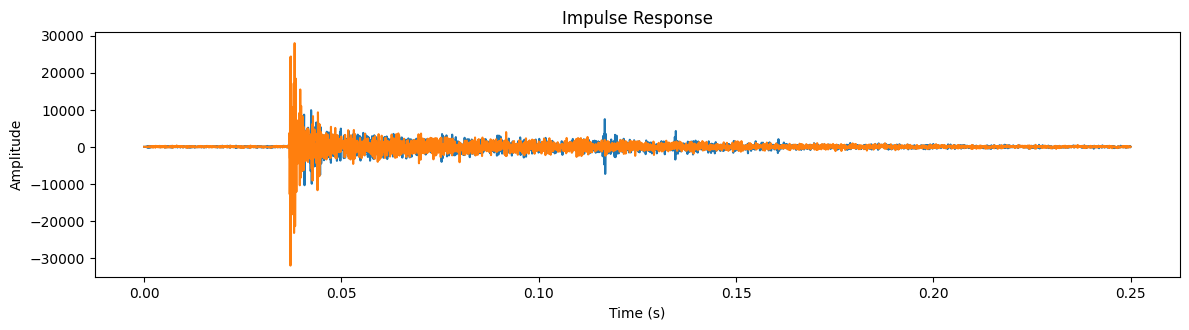

In [31]:

def plot_results(h, irShort, fs):
    plt.figure(figsize=(12, 6))

    # plt.subplot(2, 1, 1)
    # plt.plot(np.abs(h))
    # plt.title('Filter Coefficients (Magnitude)')
    # plt.xlabel('Frequency Bins')
    # plt.ylabel('Magnitude')

    plt.subplot(2, 1, 2)
    time = np.arange(irShort.shape[0]) / fs
    plt.plot(time, irShort)
    plt.title('Impulse Response')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# 可视化结果
plot_results(h, irShort, fs_clean)

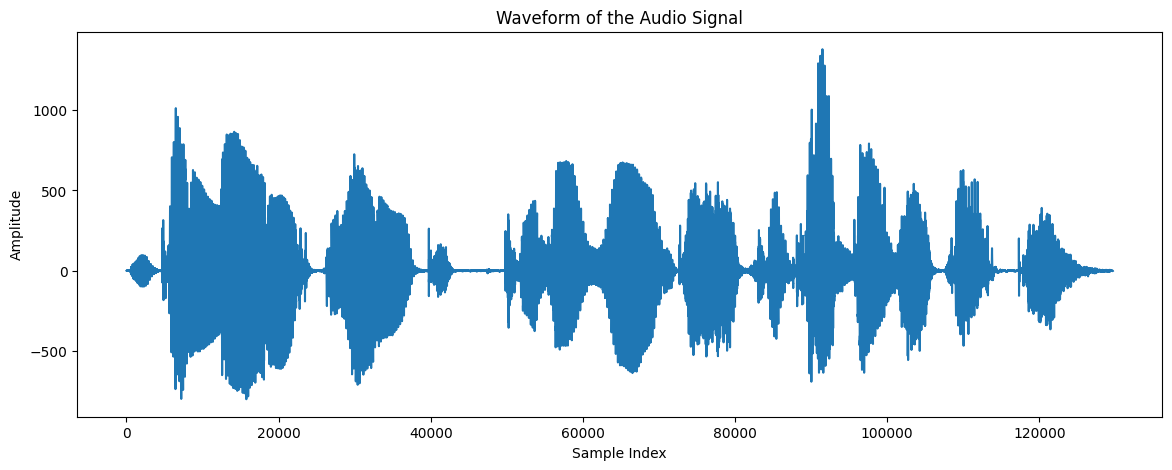

In [32]:

# 绘制时域波形
plt.figure(figsize=(14, 5))
plt.plot(clean_signal)
plt.title('Waveform of the Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()


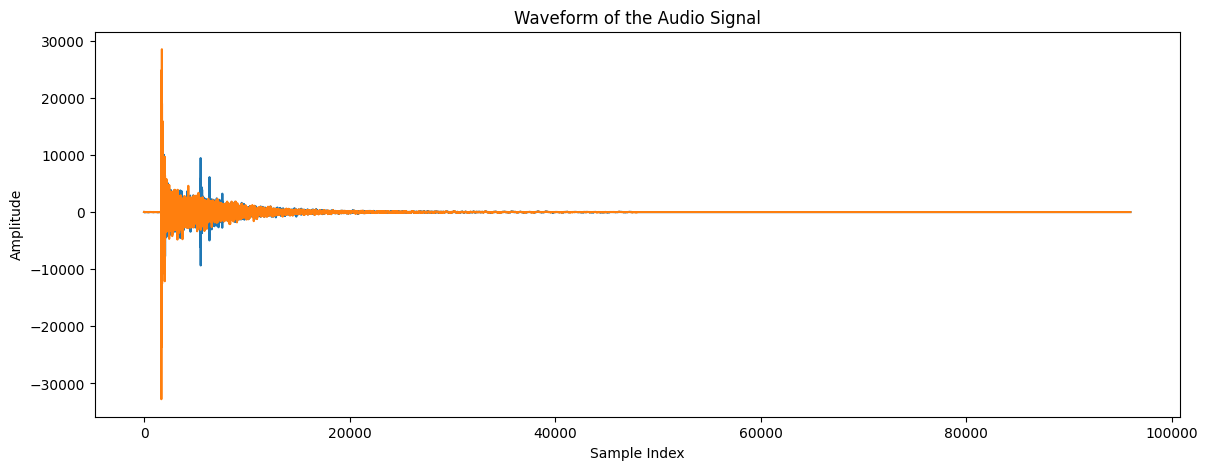

In [33]:
# 绘制时域波形
plt.figure(figsize=(14, 5))
plt.plot(binaural_ir)
plt.title('Waveform of the Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

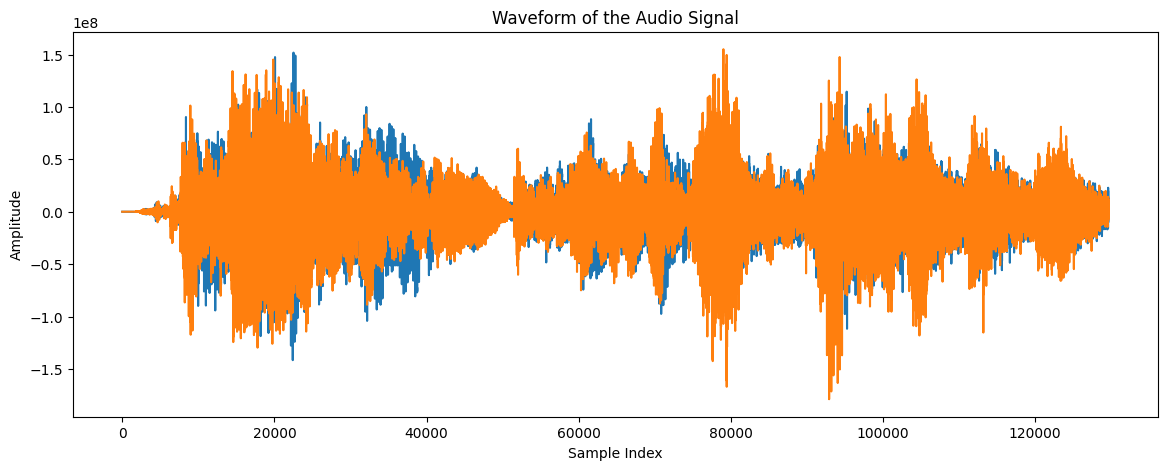

In [ ]:

# 绘制时域波形
plt.figure(figsize=(14, 5))
plt.plot(reverberant_signal)
plt.title('Waveform of the Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()